## The main goal of this project in my mind (for now) is to understand the structure of a giant planet's envelope following its accretion sequence. 

## Lets imagine a 1 Earth_mass body accreting solids (pebbles ? ie Lambrechts and Johansen) and growing into a giant planet core (10 Earth_mass). The solids will mostly be disolved in the envelope well before hitting the core (cf. Bodenheimer et al. 1986 and Podolak et al. 1988). 

## This will change the mean molecular weight in the envelope, thus possibly leading to (or quenching ?) convection or semi-convection if (grad(thermal) - grad(adiabatic)) is comparable to grad(mean-molecular-weight) (Leconte & Chabrier 2012).  

## This problem is important and has not been studied so far to my knowledge. It is however numerically challenging and necessitate integrating multiple aspects of planets formation and envelope evolution:

## An accretion rate must be chosen in addition to particles characteristic size (spectrum ?) and chemical composition, since these will effect where in the envelope a particle will sublimate. Then an envelope thermal structure must be specified. 
## This will depend on the opacity that depend on the assumptions taken on the solid particles. Should we include grains growth ? (Ormel..) or grains destruction (Thompson) ?  
## It is also very important to well characterize the transport mechanisms in the envelope (diffusion and advection), maybe following equation 6 in Theado & Vauclair 2012.

## So basically the equations to solve are the following:

## 1- The classical atmospheric structure equations giving the pressure and thermal profiles.

## 2- Particles drift and sublimation in the envelope equations 

## 3- Particles growth/destruction equations ? (or not as a first approach ?)

## 4- The mean molecular weight evolution equation (diffusion+advection)

## 5- Couple all of the above... 

## In the code below I have included all of the above except #3, and a very simplified version of #4 as a proof of principle. These are the two points I am working on now. 

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import scipy as sp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
#import seaborn
from matplotlib import colors
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import random
from scipy.sparse import diags

# Constants 
Diff=3e15
lambdacn=0.5
nteps=1000
deltat=5.0e8
deltat2=10000.*365*3600*24
Mdotdisk=1e-5
Rini=1.
rhoc=3.2
rhos=3.2 
rhos2=3.2 
psize=1e-4
adiagrad=0.28
Zgr=1e-8
T0=150.
d0=1e-11
ggrav=6.674e-8
stephboltz=5.67e-5
boltz=1.38e-16
random.seed(42)
vs= 2.992e-23
mudisk=2.34 * 1.67e-24
mcore=1.1*5.97e27
xfinind=0
xfin=[]
mu = np.empty(nteps)
mu.fill(2.34 * 1.67e-24)
timeabs=[]

# Define some arrays
dMassice=np.zeros(nteps)
radgradtot2=np.zeros(nteps)
mugrad=np.empty(nteps)
ledouxgrad=np.empty(nteps)


# This  function contains the atmospheric structure equations (pressure, temperature, state..)
def g(y, x):
    global radgradtot
    global adiagrad
    global posx

    xx = np.logspace(12,8.7,nteps)
    posx = find_nearest(xx,x)    
    radgradtot=(radgradp*(y[0]/((y[1])**4.))*((1e-8*(((y[0]*mu[posx])/(y[1]*boltz))**(2./3))*(y[1]**(3.))) +
         ((min(2.,Qep*y[1]))*3*Zgr/(4*rhos*psize))))
    adiagrad=0.28
    radgradtotind.append(radgradtot)
    adiagradind.append(adiagrad)
    
    y0 = -(ggrav*mcore*mu[posx]/boltz)*(y[0]/y[1])*(1/(x**2))
    y1 = -y0*(y[1]/y[0])*(-1)*min(adiagrad,radgradtot)         
    return y0, y1

# This function calculates the speed of sound
def cs(Temp,pos):
    cs=np.sqrt(1.6*boltz*Temp/mu[pos])
    return cs

# This function calculates the drift (gas drag) speed of a particle in the envelope
def vdrag(R,pos):
    vdrag=rhos2*R*((Pressure[pos+1]-Pressure[pos-1])/(x[pos+1]-x[pos-1]))/(cs(Temp,pos)*(Density[pos]*d0)**2)
    return vdrag

# This function calculates the sublimation rate of a particle in the envelope
def drdt(R,Temp):
    def pp(Temp):
        pp=1.013e6*10**(-24605/Temp+13.176)
        return pp    
    A=(vs*0.63/(np.sqrt(2*3.14*boltz*(4./3)*3.14*rhos)))*((pp(Temp))/(np.sqrt(Temp)))
    k1=deltat*A*(1/(np.sqrt(R**3)))
    drdt=k1
    return drdt

# This function evolves the particle size due to sublimation and drift in the envelope by calling
# the above functions iteratively.
def subR(Rini):   
    global Temp
    R=Rini
    timeind=1
    num=1
    while (num <= (nteps-3)):
        while (timeind <= 99999999):
            if (R > 0.):
                Temp=sol[num,1]
                R=R-drdt(R, Temp)                
                time=timeind*deltat
                travdist=abs(vdrag(R,num)*time)        
                if (travdist >= abs(x[num]-x[(num+1)])):
                    if (num <= (nteps-3)):
                        num=num+1
                    timeind=1.
            if (R <= 0.):
                break
        if (R <= 0.):
            break            
            timeind=timeind+1
    return num

# Never mind
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

# Crank-Nicholson routine to solve PDE (in this case the diffusion & advection equation of the mean molecular weight)
def CNX(X):
    b=Diff*deltat/(xgrad**2)
    b1=lambdacn*b
    b2=(1-lambdacn)*b
    a=2*Diff*deltat/(2*xgrad*x)
    a1=lambdacn*a
    a2=(1-lambdacn)*a
    A=np.zeros(sizemesh)
    B=np.zeros(sizemesh)
    C=np.zeros(sizemesh)
    D=np.ones(sizemesh)
    A[:]=-a1-b1
    B[:]=1+2*b1
    C[:]=a1-b1
    Ap=A[1:sizemesh]
    Ap=np.append(Ap,0 )
    A=Ap
    C=np.insert(C,0,0 )
    C=np.delete(C, sizemesh)
    B[0]=1.
    C[0]=-1.
    C[1]=-1.
    D[0]=0.
    A[sizemesh-1]=1.
    A[sizemesh-2]=1.
    B[sizemesh-1]=-1.
    D[sizemesh-1]=0.
    M = sp.sparse.dia_matrix(([B, C, A], [0, 1, -1]), shape=(sizemesh, sizemesh))
    M = M.todense()
    for i in range (1,sizemesh-1,1):
        D[i]=((a2[i]+b2[i])*X[i+1]+(1-2*b2[i])*X[i]+(b2[i]-a2[i])*X[i-1])
    X=sp.sparse.linalg.spsolve(M,D)    
    return X


# The main time loop calculating self-consistently at each time step:
# 1- the envelope structure
# 2- Where in the envelope does the accreted particles sublimate
# 3- The resulting mean-molecular weight 
# 4- The evolution of the MMW, but I am using a constant diffusion constant, have not integrated the equation
#    from Vauclair yet, next on my todo list.
# 5- Stops when 5 Earth masses are reached
# 
# This code is just a working proof of principle, still working on it.

for j in range(1,99999,1):
    timeabs.append(j*deltat2)
    
    mcore=(mcore+Mdotdisk*(5.97e27/(365*3600*24))*deltat2)

    init = (d0*boltz*T0)/(mudisk) , T0
    Rcore=(3*mcore/(4*3.14*rhoc))**(1./3)
    Bondi = (ggrav*mcore/(boltz*T0/mudisk))/Rcore
    mdottot=Mdotdisk*(5.97e27/(365*3600*24))
    radgradp=(3*mdottot)/(64*3.14*stephboltz*Rcore)
    Qep=(0.3*2*3.14*psize)/(0.289)
    dMassg=np.zeros(nteps)
    x = np.logspace(12,8.7,nteps)
    sizemesh=len(x)
    xgrad=np.gradient(x)
    
    radgradtotind=[]
    adiagradind=[]


    sol=odeint(g, init, x)  

    Density = (((sol[:,0]*mu)/(boltz*sol[:,1])))
    Temperature = (sol[:,1])/T0
    Pressure=sol[:,0]


    dMassg=((4/3)*3.14*Density*((np.diff(x,n=0))**3))        
        
        
    if (Rini > 0):
        xfin.append(x[subR(Rini)]/Rcore)
        dMassice[subR(Rini)]=dMassice[subR(Rini)] + 1e-5*(5.97e27)*deltat2
    mu=(1./(((dMassg/(dMassg+dMassice))/2.2)+(((dMassice)/(dMassg+dMassice))/18.))) * 1.67e-24
    mu[np.isnan(mu)] = 2.34 * 1.67e-24#
    mu=CNX(mu)

    for i in range(1,nteps-1,1):
        radgradtot2[i]=((radgradp*(sol[i,0]/((sol[i,1])**4.))*((1e-8*(((sol[i,0]*mu[i])/(sol[i,1]*boltz))**(2./3))*(sol[i,1]**(3.))) +
                         ((min(2.,Qep*sol[i,1]))*3*Zgr/(4*rhos*psize)))))
    mugrad=(np.gradient(np.log(mu)))/(np.gradient(np.log(Pressure)))
    ledouxgrad=(radgradtot2-mugrad)
    
    if (mcore >= 5*(5.97e27)):
        break
    

/home/mad/anaconda2/lib/python2.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:101: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


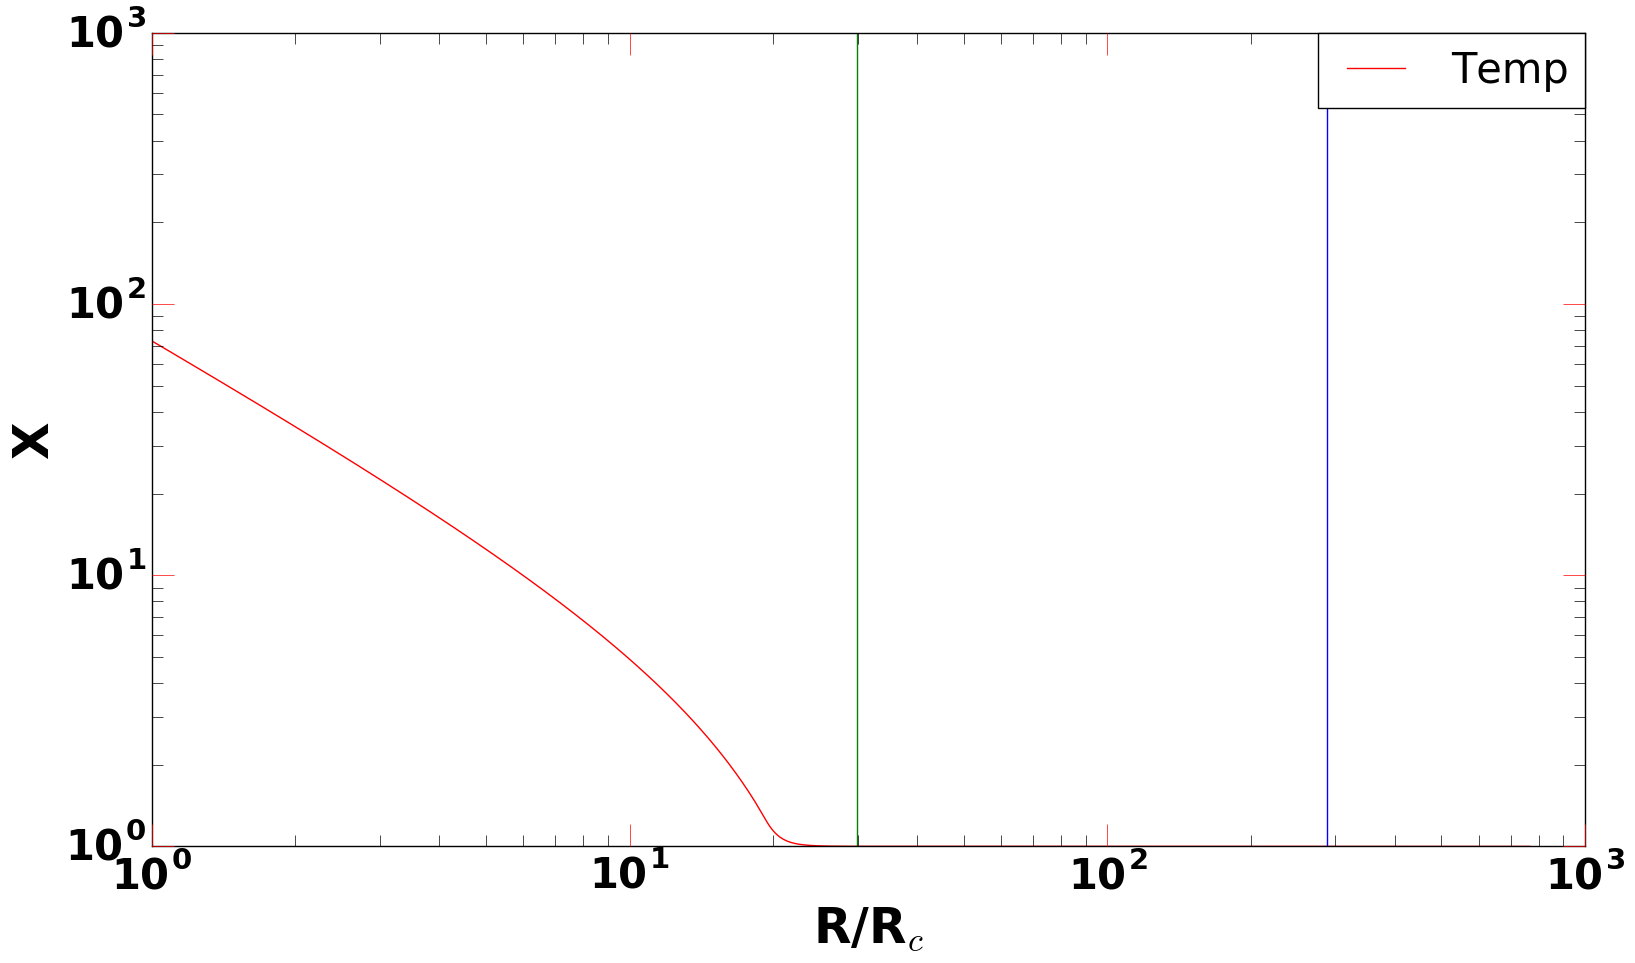

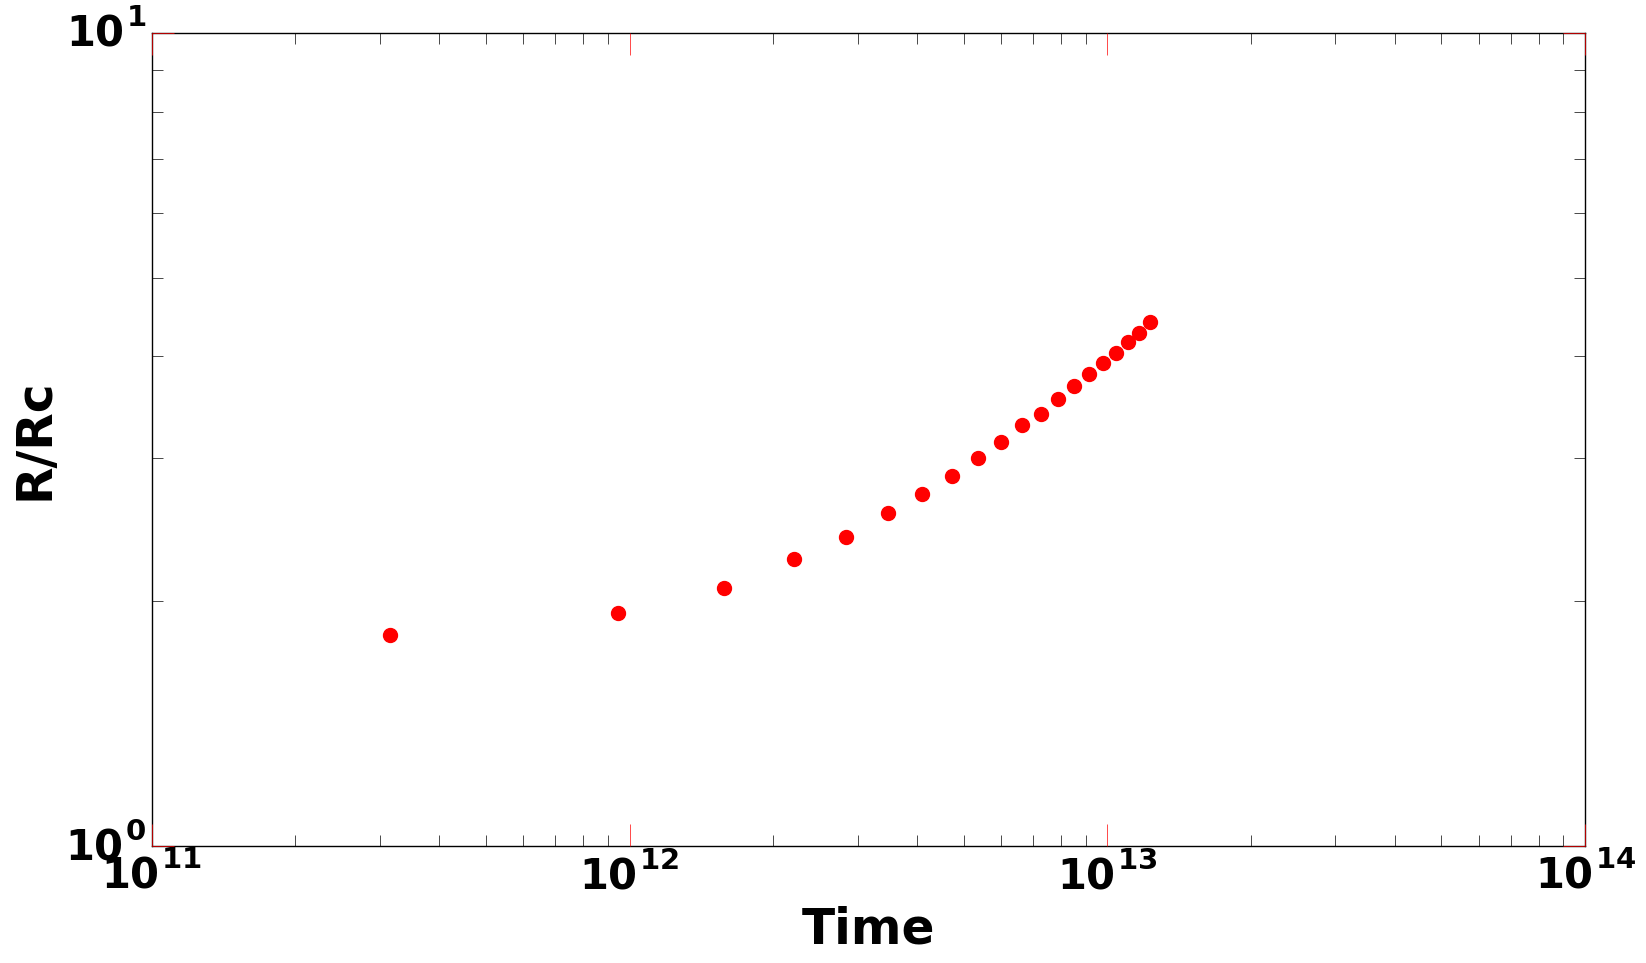

In [2]:
# This is the plotting module, everything below is to generate plots.
# The first plot shows the atmospheric temperature as a function of R/R_core. The green line is the 
# adiabatic/radiative boundary and the blue line is the Bondi radius.

# The second plot shows where/when does the accreted particles sublimate. 


adialim=0
adialimledoux=adialim

for i in range(1,len(radgradtot2)-1,1):
    if (radgradtot2[i] < adiagrad):
        adialim=i
        
for i in range(adialim,len(radgradtot2),1):
    if (ledouxgrad[i] > adiagrad):
        adialimledoux=i


plt.plot(x/Rcore, Temperature, color='r',label='Temp')
plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize = 30, fontweight='bold')
plt.yticks(fontsize = 30, fontweight='bold')
plt.tick_params(which='minor', length=8)
plt.tick_params(which='major', length=16, color='r')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.legend(loc=1, borderaxespad=0., fontsize=30)
ax = plt.gca()
legend = ax.get_legend()
legend.legendHandles[0].set_color('red')
plt.ylabel('X', fontsize=35, fontweight='bold')
plt.xlabel('R/R$_c$', fontsize=35, fontweight='bold')
plt.axis((1,1000,1,1e3))


plt.plot((Bondi, Bondi), (-1e-9,1e9), 'blue')

plt.plot((x[adialim]/Rcore, x[adialim]/Rcore), (-1e-9,1e9), 'green')
plt.plot((x[adialimledoux]/Rcore, x[adialimledoux]/Rcore), (-1e-9,1e9), 'yellow')

plt.show()

plt.scatter(timeabs,xfin, s=10*(4/3)*3.14*rhos*(Rini**3), color='r',label='Temp')
plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize = 30, fontweight='bold')
plt.tick_params(which='minor', length=8)
plt.tick_params(which='major', length=16, color='r')
plt.axis((1e11,1e14,1,10))
plt.yticks(fontsize = 30, fontweight='bold')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)

plt.ylabel('R/Rc', fontsize=35, fontweight='bold')
plt.xlabel('Time', fontsize=35, fontweight='bold')
plt.show()         
    

    